# Finding interrelations of the UN SDG Targets and impute missing observations

### This project is divided into two major phases: 
1. It is intended to find cliques within the [UN SDG](https://sustainabledevelopment.un.org/?menu=1300) Targets.
2. Within one of the found cliques, missing observations of the time-series are inferred

Each Target has at least one quantitatively measurable Indicator associated whose measurements from 1984 to 2017 serve as our data points. The data set we are working with is for the entire world, i.e. the values presented are means over all countries. Regarding the first phase, for a more sophisticated analysis, but out of scope of this course, correlations in each country should be analysed separately.

<img src="Screenshot from 2018-04-19 10-08-40.png">

## 1. Find cliques

Import necessary packages and load our preprocessed data set

*if you want to see what happened in the preprocessing, see **prepare_df_for_analysis.ipynb** *

In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import pystan
import math
import os
import sklearn

In [2]:
# load csv
df = pd.read_csv("TargetsForAnalysis.csv")
df.head()

,Unnamed: 0,Category,Indicator Description,Goal,Target,Indicator Ref,Unit,Unit multiplier,1984,1985,...,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017
0,106,Population,Proportion of population below the internation...,1,1.1,1.1.1,Percent,Units,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,10.7,NaN,NaN,NaN,NaN
1,107,Population,Proportion of population covered by social pro...,1,1.3,1.3.1,Percent,Units,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,45.17,NaN
2,108,Population,Proportion of population covered by social pro...,1,1.3,1.3.1,Percent,Units,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,34.86,NaN
3,109,Population,Proportion of population covered by social pro...,1,1.3,1.3.1,Percent,Units,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,27.79,NaN
4,110,Population,Proportion of population covered by social pro...,1,1.3,1.3.1,Percent,Units,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,41.08,NaN


As we can see in the dataframe above, we have several rows (measurements) for the same target. To make the best possible analysis, we would like to use the measurements with most values for each target.

That's why we first count the number of values for each row and then filter the targets for the rows with most values.

In [3]:
intyears = list(range(1984, 2018))
#print(intyears)

years = []
for year in intyears:
    years.append(str(year))
    
#print(years)

In [4]:
def getnumberofyearswithdata(r):
    n = 0
    for year in years:
        if ~np.isnan(r[year]):
            n+=1
    return n

In [5]:
# new column with number of data points per Indicator
df['Years with values'] = df.apply(getnumberofyearswithdata, axis=1)

We need at least two data points to conclude any kind of correlation

In [6]:
df_new = df.loc[df['Years with values'] > 1]

# see how many rows we deleted
print(df_new.shape)
df_new.head()

(120, 43)


,Unnamed: 0,Category,Indicator Description,Goal,Target,Indicator Ref,Unit,Unit multiplier,1984,1985,...,2009,2010,2011,2012,2013,2014,2015,2016,2017,Years with values
0,106,Population,Proportion of population below the internation...,1,1.1,1.1.1,Percent,Units,NaN,NaN,...,NaN,NaN,NaN,NaN,10.70,NaN,NaN,NaN,NaN,2
8,115,Population,Proportion of births attended by skilled healt...,3,3.1,3.1.2,Percent,Units,NaN,NaN,...,NaN,69.88,NaN,NaN,NaN,NaN,NaN,78.49,NaN,3
9,129,Population,Participation rate in organized learning (one ...,4,4.2,4.2.2,Percent,Units,NaN,NaN,...,59.41,60.44,62.64,64.64,65.20,66.59,NaN,NaN,NaN,12
10,130,Population,Proportion of population using safely managed ...,6,6.1,6.1.1,Percent,Units,NaN,NaN,...,54.02,55.55,55.91,55.77,55.22,55.03,54.81,NaN,NaN,16
11,131,Population,Proportion of population using safely managed ...,6,6.1,6.1.1,Percent,Units,NaN,NaN,...,69.90,70.82,71.14,71.22,71.09,71.14,71.16,NaN,NaN,16


See how many Targets are associated with the Indicators we found

In [7]:
df_new['Target'] = df_new.apply(lambda x: str(x['Target']), axis=1)

/Users/GalinaJonat/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


See which Targets are left in our data frame.

In [8]:
targets = list(set(df_new['Target']))

We know that one Target can have potentially more than one Indicator, and that Indicators can be separetely measured for, e.g., genders, age groups, etc.
But since we want to find interrelations between the Targets, only the row per Target with maximum amount of data is considered.

In [9]:
# create empty dictionary
target_dfs = {}

In [10]:
for t in targets:
    target_dfs[t] = df_new[df_new['Target']==t]

In [11]:
# example of Target with more than one Indicator
target_dfs['12.2']

,Unnamed: 0,Category,Indicator Description,Goal,Target,Indicator Ref,Unit,Unit multiplier,1984,1985,...,2009,2010,2011,2012,2013,2014,2015,2016,2017,Years with values
177,77,Environment (Tonnes),"Material footprint, material footprint per cap...",12,12.2,12.2.1,Metric Tons,Units,NaN,NaN,...,9.690000e+00,1.010000e+01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,11
178,78,Environment (Tonnes),"Material footprint, material footprint per cap...",12,12.2,12.2.1,Metric Tons,Units,NaN,NaN,...,1.330000e-03,1.330000e-03,NaN,NaN,NaN,NaN,NaN,NaN,NaN,11
179,79,Environment (Tonnes),"Material footprint, material footprint per cap...",12,12.2,12.2.1,Metric Tons,Units,NaN,NaN,...,6.573055e+16,6.932903e+16,NaN,NaN,NaN,NaN,NaN,NaN,NaN,11
183,83,Environment (Tonnes),"Domestic material consumption, domestic materi...",12,12.2,12.2.2,Metric Tons,Units,NaN,NaN,...,9.750000e+00,1.006000e+01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,11
184,84,Environment (Tonnes),"Domestic material consumption, domestic materi...",12,12.2,12.2.2,Metric Tons,Units,NaN,NaN,...,1.330000e-03,1.330000e-03,NaN,NaN,NaN,NaN,NaN,NaN,NaN,11
185,85,Environment (Tonnes),"Domestic material consumption, domestic materi...",12,12.2,12.2.2,Metric Tons,Units,NaN,NaN,...,6.807354e+16,7.099971e+16,NaN,NaN,NaN,NaN,NaN,NaN,NaN,11


In [12]:
# find row with maximum amount of data points for each target
max_dfrows = {}

for target in targets:
    if target_dfs[target].shape[0] > 1:
        max_dfrows[target] = target_dfs[target].loc[target_dfs[target]['Years with values'].idxmax()].to_frame().T
    else:
        max_dfrows[target]=target_dfs[target]

In [13]:
frames = list(max_dfrows[target] for target in targets)

In [14]:
merged_df = pd.concat(frames, axis=0)

In [15]:
units = list(set(merged_df['Unit']))

We know that most of our Indicators are given in the unit 'percent', but we want to see here what are other units

In [16]:
units.remove('Percent')
units

['Metric Tons', 'Constant USD', 'USD']

Which and how many Indicators are expressed in other units than 'percent'?

In [17]:
not_percent = merged_df[merged_df['Unit'].isin(units)]
not_percent

,Unnamed: 0,Category,Indicator Description,Goal,Target,Indicator Ref,Unit,Unit multiplier,1984,1985,...,2009,2010,2011,2012,2013,2014,2015,2016,2017,Years with values
191,95,Environment (Tonnes),CO2 emission per unit of value added,9,9.4,9.4.1,Metric Tons,Units,NaN,NaN,...,2.87486e+10,3.04504e+10,3.13544e+10,3.15929e+10,3.21294e+10,3.2381e+10,NaN,NaN,NaN,15
174,74,Environment (Tonnes),"Material footprint, material footprint per cap...",8,8.4,8.4.1,Metric Tons,Units,NaN,NaN,...,9.69,10.1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,11
140,20,E&P (Percent),"Net official development assistance, total and...",17,17.2,17.2.1,Constant USD,Billions,NaN,NaN,...,0.000114281,0.00012063,0.000119673,0.000115308,0.000121838,0.000123946,0.000131555,0.000143329,NaN,17
177,77,Environment (Tonnes),"Material footprint, material footprint per cap...",12,12.2,12.2.1,Metric Tons,Units,NaN,NaN,...,9.69,10.1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,11
141,36,E&P (USD),Dollar value of all resources made available t...,17,17.19,17.19.1,USD,Units,NaN,NaN,...,1.40685e+08,3.51996e+08,4.83067e+08,2.08601e+08,4.43106e+08,3.49844e+08,NaN,NaN,NaN,9


### Clean up data frame

To prepare the dataframe for the actual analysis, we remove unused columns and transpose the dataframe, having years of measurements as rows and targets as columns.

In [18]:
# Drop unused columns
final_df = merged_df.copy()

final_df.drop(['Unnamed: 0', 'Category', 'Indicator Description', 'Goal', 'Indicator Ref', 'Unit',
              'Unit multiplier', 'Years with values'], inplace=True, axis=1)

final_df = final_df.set_index('Target')

# transpose
final_t = final_df.T

targets = list(final_t.columns)

Normalize the data set to reduce any covariate shift

In [19]:
def normalize_df(df):
    return (df -df.mean())/df.std()

In [20]:
final_t = normalize_df(final_t)

In [21]:
# shuffle data
final_t_shuffled = sklearn.utils.shuffle(final_t, random_state=200)

### Structure Learning

We learn the structure of the network by deploying linear regression and calculate error measurements. In detail, we say that a correlation between two Targets exists, if the (standardized) correlation coefficient is higher than 0.9.

In [22]:
import sklearn
from sklearn import linear_model
from sklearn.preprocessing import Imputer

In [23]:
def compute_error(trues, predicted):
    mae = np.mean(np.abs(predicted - trues))
    rmse = np.sqrt(np.mean((predicted - trues)**2))
    
    if len(trues)>2:
        rae = np.sum(np.abs(predicted - trues)) / np.sum(np.abs(trues - np.mean(trues)))
        r2 = max(0, 1 - np.sum((trues-predicted)**2) / np.sum((trues - np.mean(trues))**2))
    else:
        rae = np.nan
        r2 = np.nan
    return mae, rae, rmse, r2

/Users/GalinaJonat/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:19: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
/Users/GalinaJonat/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:20: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead


9.4 17.8
MAE: 0.15876
RMSE: 0.19610
R2: 0.951
Coefficient 0.8886069421260533
--------------------------




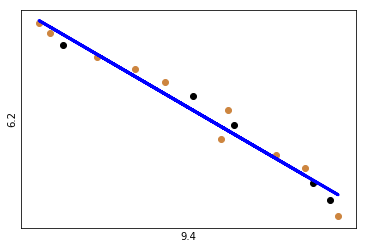

9.4 6.2
MAE: 0.14356
RMSE: 0.17332
R2: 0.963
Coefficient -0.9041987684604176
--------------------------


9.4 4.2
MAE: 0.41415
RMSE: 0.51867
R2: 0.687
Coefficient 1.6064469801761934
--------------------------


9.4 8.1
MAE: 0.89059
RMSE: 1.16773
R2: 0.000
Coefficient -0.04974666236196581
--------------------------


9.4 10.c
MAE: 0.40131
RMSE: 0.40488
R2: nan
Coefficient -3.916067094972819
--------------------------


9.4 17.3
MAE: 0.22295
RMSE: 0.30057
R2: 0.901
Coefficient 0.8046264761285794
--------------------------




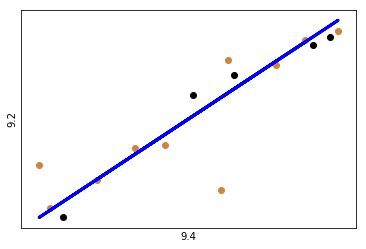

9.4 9.2
MAE: 0.29835
RMSE: 0.49544
R2: 0.691
Coefficient 0.9598371559007554
--------------------------


9.4 7.2
MAE: 0.74157
RMSE: 0.82041
R2: 0.210
Coefficient 0.767161222308168
--------------------------




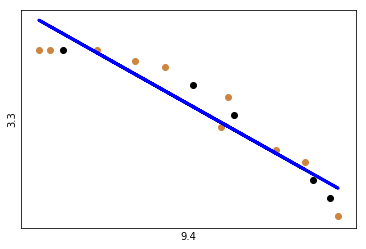

9.4 3.3
MAE: 0.25686
RMSE: 0.30761
R2: 0.875
Coefficient -0.9163885922281056
--------------------------




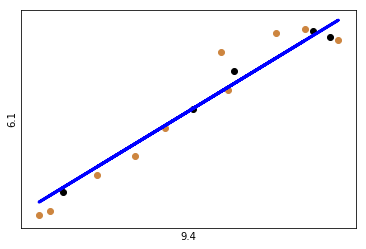

9.4 6.1
MAE: 0.21704
RMSE: 0.26384
R2: 0.932
Coefficient 0.9115565381972615
--------------------------


9.4 9.5
MAE: 0.14531
RMSE: 0.16699
R2: 0.969
Coefficient 1.000403873592152
--------------------------




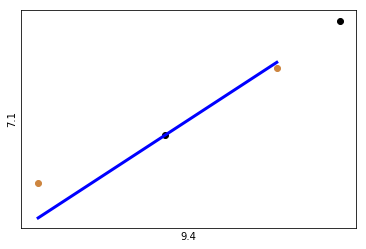

9.4 7.1
MAE: 0.28048
RMSE: 0.34757
R2: nan
Coefficient 0.954187317475595
--------------------------


9.4 14.4
MAE: 0.75816
RMSE: 0.76315
R2: 0.322
Coefficient 0.8984980984423888
--------------------------


9.4 8.4
MAE: 0.07592
RMSE: 0.08359
R2: 0.992
Coefficient 1.2759265350061901
--------------------------


9.4 17.2
MAE: 0.31334
RMSE: 0.37605
R2: 0.833
Coefficient 0.7276401493722522
--------------------------


9.4 12.2
MAE: 0.07592
RMSE: 0.08359
R2: 0.992
Coefficient 1.2759265350061901
--------------------------




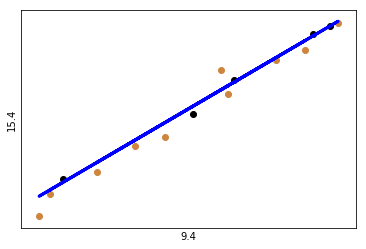

9.4 15.4
MAE: 0.14299
RMSE: 0.17192
R2: 0.966
Coefficient 0.9089213268967578
--------------------------


9.4 15.1
MAE: 0.22246
RMSE: 0.26830
R2: 0.928
Coefficient 0.8947081942979308
--------------------------


9.4 3.6
MAE: 1.74847
RMSE: 2.30871
R2: nan
Coefficient -1.535310156676165
--------------------------




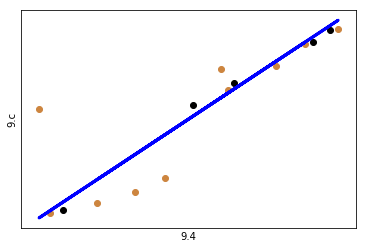

9.4 9.c
MAE: 0.37700
RMSE: 0.58446
R2: 0.626
Coefficient 0.9815068607139434
--------------------------


9.4 17.19
MAE: 1.20712
RMSE: 1.34849
R2: 0.000
Coefficient 0.23135566975827798
--------------------------


9.4 2.1
MAE: 0.20236
RMSE: 0.23566
R2: 0.855
Coefficient -0.6464032188731045
--------------------------


9.4 8.2
MAE: 0.93958
RMSE: 1.14854
R2: 0.000
Coefficient 0.0195028763165806
--------------------------


3.1 17.8
MAE: 0.60516
RMSE: 0.70139
R2: nan
Coefficient -1.7746587937038723
--------------------------


3.1 6.2
MAE: 0.48785
RMSE: 0.55589
R2: nan
Coefficient 1.6836471876888013
--------------------------


3.1 8.1
MAE: 0.32631
RMSE: 0.46032
R2: nan
Coefficient 0.44360601120067766
--------------------------


3.1 17.3
MAE: 0.11505
RMSE: 0.12346
R2: nan
Coefficient -1.4451471044362951
--------------------------


3.1 14.5
MAE: 0.61476
RMSE: 0.77527
R2: nan
Coefficient -1.350270648321205
--------------------------


3.1 3.4
MAE: 0.13611
RMSE: 0.15590
R2: nan
Coefficient 

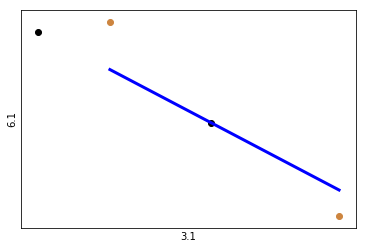

3.1 6.1
MAE: 0.50190
RMSE: 0.52229
R2: nan
Coefficient -0.927825820267653
--------------------------


3.1 17.2
MAE: 0.85716
RMSE: 1.08358
R2: nan
Coefficient -0.5731612835865451
--------------------------


3.1 15.4
MAE: 0.12352
RMSE: 0.12505
R2: nan
Coefficient -1.3018420416359762
--------------------------




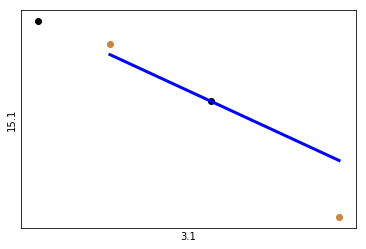

3.1 15.1
MAE: 0.50557
RMSE: 0.60930
R2: nan
Coefficient -0.909519447353561
--------------------------


3.1 9.c
MAE: 1.45785
RMSE: 1.82163
R2: nan
Coefficient -1.5970822553962094
--------------------------


3.1 3.9
MAE: 0.16868
RMSE: 0.19839
R2: nan
Coefficient 0.871410146541922
--------------------------


3.1 16.a
MAE: 0.40194
RMSE: 0.52239
R2: nan
Coefficient -0.6898311305707241
--------------------------


3.1 2.1
MAE: 0.59715
RMSE: 0.75569
R2: nan
Coefficient 1.211752739769449
--------------------------


3.1 8.2
MAE: 1.11253
RMSE: 1.22419
R2: nan
Coefficient 0.6928389110748264
--------------------------




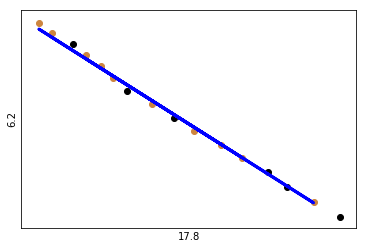

17.8 6.2
MAE: 0.04687
RMSE: 0.05558
R2: 0.996
Coefficient -0.9789785504316588
--------------------------


17.8 4.2
MAE: 0.18296
RMSE: 0.25614
R2: 0.924
Coefficient 1.2742919528968017
--------------------------


17.8 8.1
MAE: 0.86503
RMSE: 1.15933
R2: 0.000
Coefficient -0.0409838103903029
--------------------------


17.8 10.c
MAE: 0.42352
RMSE: 0.60496
R2: 0.000
Coefficient -3.2606871368111303
--------------------------


17.8 17.3
MAE: 0.29951
RMSE: 0.38363
R2: 0.838
Coefficient 0.8189482620073496
--------------------------


17.8 14.5
MAE: 0.20257
RMSE: 0.25465
R2: nan
Coefficient 0.760862117896516
--------------------------


17.8 3.4
MAE: 0.28675
RMSE: 0.36359
R2: nan
Coefficient -0.5943279590017242
--------------------------


17.8 9.2
MAE: 0.38766
RMSE: 0.54788
R2: 0.622
Coefficient 0.8398500117397502
--------------------------


17.8 7.2
MAE: 0.62876
RMSE: 0.71744
R2: 0.396
Coefficient 1.0218089157008206
--------------------------


17.8 3.3
MAE: 0.12255
RMSE: 0.16056
R2: 0.96

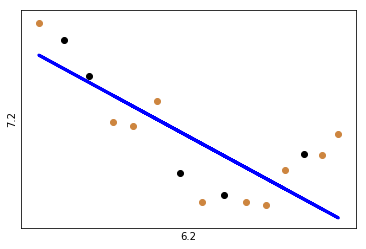

6.2 7.2
MAE: 0.64134
RMSE: 0.73169
R2: 0.372
Coefficient -0.972620310763738
--------------------------


6.2 3.3
MAE: 0.14655
RMSE: 0.19978
R2: 0.947
Coefficient 1.038437108197621
--------------------------


6.2 6.1
MAE: 0.37208
RMSE: 0.40995
R2: 0.835
Coefficient -0.7767648516377597
--------------------------


6.2 9.5
MAE: 0.06497
RMSE: 0.09020
R2: 0.991
Coefficient -1.093435806186652
--------------------------


6.2 7.1
MAE: 0.05737
RMSE: 0.06046
R2: nan
Coefficient -0.7978678300733478
--------------------------


6.2 14.4
MAE: 0.55094
RMSE: 0.62248
R2: 0.549
Coefficient -0.7654780550471652
--------------------------


6.2 8.4
MAE: 0.27786
RMSE: 0.33801
R2: 0.862
Coefficient -1.7420565045273628
--------------------------


6.2 17.2
MAE: 0.35812
RMSE: 0.42398
R2: 0.787
Coefficient -0.7411207402696305
--------------------------


6.2 12.2
MAE: 0.27786
RMSE: 0.33801
R2: 0.862
Coefficient -1.7420565045273628
--------------------------


6.2 15.4
MAE: 0.19515
RMSE: 0.23254
R2: 0.938
Coe

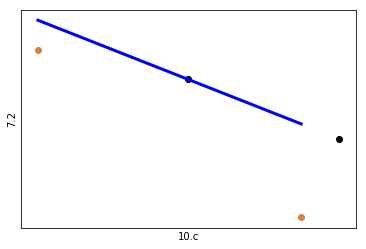

10.c 7.2
MAE: 0.63134
RMSE: 0.71080
R2: nan
Coefficient -0.9307200492406918
--------------------------


10.c 3.3
MAE: 0.19037
RMSE: 0.21665
R2: 0.613
Coefficient 0.3033023126698934
--------------------------


10.c 6.1
MAE: 0.04357
RMSE: 0.04411
R2: 0.580
Coefficient 0.07037808623927454
--------------------------


10.c 9.5
MAE: 0.17769
RMSE: 0.19235
R2: nan
Coefficient -0.3254349453678243
--------------------------


10.c 17.2
MAE: 0.08592
RMSE: 0.10674
R2: 0.000
Coefficient -0.30959491390706206
--------------------------


10.c 15.4
MAE: 0.13154
RMSE: 0.15784
R2: 0.245
Coefficient -0.0713944807440347
--------------------------


10.c 15.1
MAE: 0.08060
RMSE: 0.09238
R2: 0.346
Coefficient -0.05602614924331137
--------------------------


10.c 9.c
MAE: 0.08525
RMSE: 0.09082
R2: 0.142
Coefficient -0.07026217478076477
--------------------------


10.c 17.19
MAE: 2.26854
RMSE: 2.31612
R2: nan
Coefficient -2.9883946733044695
--------------------------


10.c 2.1
MAE: 0.07699
RMSE: 0.10691


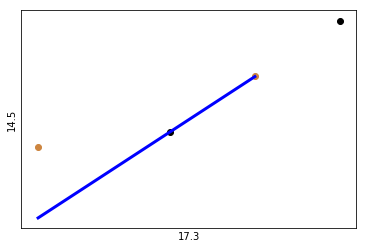

17.3 14.5
MAE: 0.57984
RMSE: 0.81513
R2: nan
Coefficient 0.9343482363671911
--------------------------


17.3 3.4
MAE: 0.10341
RMSE: 0.10372
R2: nan
Coefficient -0.7298421977587536
--------------------------


17.3 9.2
MAE: 0.45934
RMSE: 0.71698
R2: 0.353
Coefficient 1.048852343506756
--------------------------


17.3 7.2
MAE: 0.68262
RMSE: 0.84506
R2: 0.162
Coefficient 0.7533687743432663
--------------------------


17.3 3.3
MAE: 0.38043
RMSE: 0.49625
R2: 0.674
Coefficient -1.0964851225104162
--------------------------




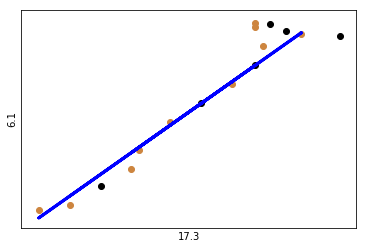

17.3 6.1
MAE: 0.19907
RMSE: 0.28490
R2: 0.920
Coefficient 0.9002938845191208
--------------------------


17.3 9.5
MAE: 0.22633
RMSE: 0.30725
R2: 0.897
Coefficient 1.1734708619868623
--------------------------


17.3 7.1
MAE: 0.50282
RMSE: 0.65151
R2: nan
Coefficient 1.072334542846467
--------------------------


17.3 14.4
MAE: 1.01171
RMSE: 1.07949
R2: 0.000
Coefficient 1.1138815555513577
--------------------------


17.3 8.4
MAE: 0.26265
RMSE: 0.28303
R2: 0.903
Coefficient 1.150301078216763
--------------------------


17.3 17.2
MAE: 0.24994
RMSE: 0.35300
R2: 0.853
Coefficient 0.8868379716658173
--------------------------


17.3 12.2
MAE: 0.26265
RMSE: 0.28303
R2: 0.903
Coefficient 1.150301078216763
--------------------------




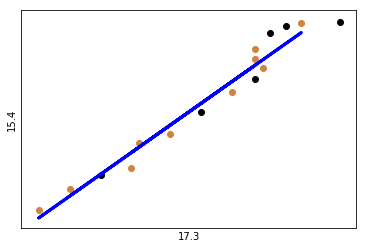

17.3 15.4
MAE: 0.14466
RMSE: 0.15525
R2: 0.973
Coefficient 0.96082312589266
--------------------------




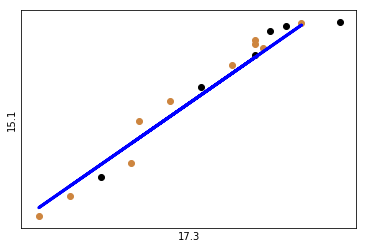

17.3 15.1
MAE: 0.17439
RMSE: 0.19367
R2: 0.963
Coefficient 0.9356832966180914
--------------------------


17.3 3.6
MAE: 2.27461
RMSE: 2.95100
R2: nan
Coefficient -1.8633640818313095
--------------------------


17.3 9.c
MAE: 0.40844
RMSE: 0.68570
R2: 0.485
Coefficient 1.018645960235765
--------------------------


17.3 3.9
MAE: 0.19570
RMSE: 0.19882
R2: nan
Coefficient -0.6029906186483561
--------------------------


17.3 16.a
MAE: 0.42333
RMSE: 0.50686
R2: nan
Coefficient 0.4773431911900795
--------------------------


17.3 17.19
MAE: 1.18499
RMSE: 1.31502
R2: 0.000
Coefficient 0.6661071488298903
--------------------------


17.3 2.1
MAE: 0.26830
RMSE: 0.32032
R2: 0.732
Coefficient -0.7221481481938149
--------------------------


17.3 8.2
MAE: 0.93883
RMSE: 1.15247
R2: 0.000
Coefficient -0.08378779138693249
--------------------------


14.5 3.4
MAE: 0.44498
RMSE: 0.56250
R2: nan
Coefficient -0.7811243916897935
--------------------------


14.5 9.2
MAE: 0.45811
RMSE: 0.54113
R2: 0.210

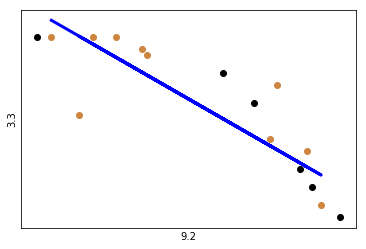

9.2 3.3
MAE: 0.44067
RMSE: 0.56567
R2: 0.576
Coefficient -0.9711278360815199
--------------------------


9.2 6.1
MAE: 0.46779
RMSE: 0.67089
R2: 0.559
Coefficient 0.8649799906792499
--------------------------




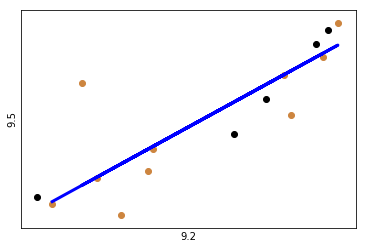

9.2 9.5
MAE: 0.38470
RMSE: 0.61403
R2: 0.587
Coefficient 0.9651850484195186
--------------------------




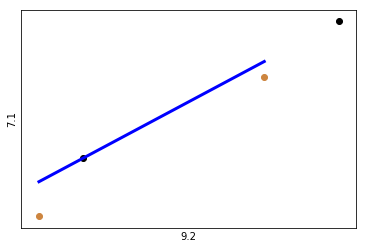

9.2 7.1
MAE: 0.29007
RMSE: 0.30911
R2: nan
Coefficient 0.993523828183931
--------------------------


9.2 14.4
MAE: 1.46087
RMSE: 1.75021
R2: 0.000
Coefficient 1.469942118314277
--------------------------


9.2 8.4
MAE: 0.48226
RMSE: 0.73341
R2: 0.350
Coefficient 1.0899953580212125
--------------------------




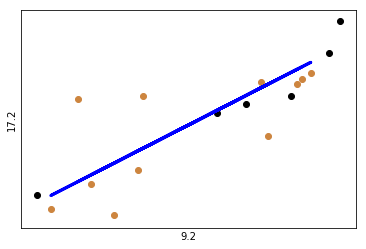

9.2 17.2
MAE: 0.51678
RMSE: 0.67008
R2: 0.471
Coefficient 0.9399562700491232
--------------------------


9.2 12.2
MAE: 0.48226
RMSE: 0.73341
R2: 0.350
Coefficient 1.0899953580212125
--------------------------


9.2 15.4
MAE: 0.38832
RMSE: 0.57534
R2: 0.651
Coefficient 0.8653283887453064
--------------------------


9.2 15.1
MAE: 0.40255
RMSE: 0.63925
R2: 0.600
Coefficient 0.8524917288276556
--------------------------


9.2 3.6
MAE: 1.13273
RMSE: 1.33480
R2: nan
Coefficient -1.6091293769407116
--------------------------




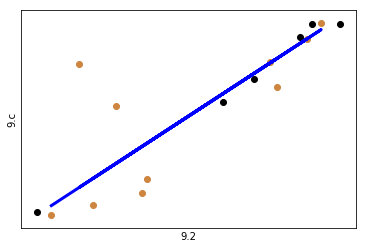

9.2 9.c
MAE: 0.45766
RMSE: 0.66334
R2: 0.518
Coefficient 0.9747028691282287
--------------------------


9.2 3.9
MAE: 0.47189
RMSE: 0.66708
R2: nan
Coefficient -0.6533042407749331
--------------------------


9.2 16.a
MAE: 0.50201
RMSE: 0.66926
R2: 0.370
Coefficient 1.1296142175002688
--------------------------


9.2 17.19
MAE: 1.11709
RMSE: 1.30305
R2: 0.000
Coefficient 0.43414621224821365
--------------------------


9.2 2.1
MAE: 0.31895
RMSE: 0.42878
R2: 0.520
Coefficient -0.644406681512749
--------------------------


9.2 8.2
MAE: 0.88012
RMSE: 1.10527
R2: 0.000
Coefficient 0.016109760188846856
--------------------------


7.2 3.3
MAE: 0.44359
RMSE: 0.55816
R2: 0.587
Coefficient -0.7446501541235103
--------------------------


7.2 6.1
MAE: 0.72975
RMSE: 0.90245
R2: 0.201
Coefficient 0.516415047370152
--------------------------


7.2 9.5
MAE: 0.56555
RMSE: 0.76062
R2: 0.367
Coefficient 0.6970947235917624
--------------------------


7.2 7.1
MAE: 0.77261
RMSE: 0.92260
R2: nan
Coeffic

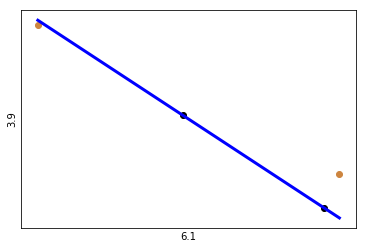

6.1 3.9
MAE: 0.30270
RMSE: 0.38638
R2: nan
Coefficient -0.9391958355831733
--------------------------


6.1 16.a
MAE: 0.44110
RMSE: 0.44204
R2: nan
Coefficient 0.7434920601495291
--------------------------


6.1 17.19
MAE: 1.22578
RMSE: 1.34511
R2: 0.000
Coefficient 0.3255249988944013
--------------------------


6.1 2.1
MAE: 0.28070
RMSE: 0.31082
R2: 0.748
Coefficient -0.7496696655656742
--------------------------


6.1 8.2
MAE: 0.95311
RMSE: 1.15914
R2: 0.000
Coefficient -0.04259419019778812
--------------------------


9.5 7.1
MAE: 0.08977
RMSE: 0.11913
R2: nan
Coefficient 0.8269159981686063
--------------------------


9.5 14.4
MAE: 0.59173
RMSE: 0.64033
R2: 0.523
Coefficient 0.7485005411121101
--------------------------


9.5 8.4
MAE: 0.24908
RMSE: 0.29219
R2: 0.897
Coefficient 1.4565766850612982
--------------------------


9.5 17.2
MAE: 0.32454
RMSE: 0.40380
R2: 0.807
Coefficient 0.6943992205888336
--------------------------


9.5 12.2
MAE: 0.24908
RMSE: 0.29219
R2: 0.897
Coeffi

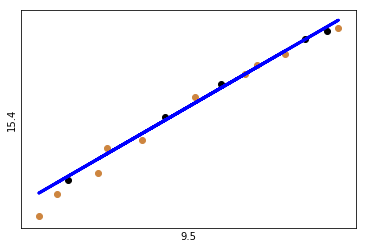

9.5 15.4
MAE: 0.12440
RMSE: 0.15691
R2: 0.972
Coefficient 0.9031785631711373
--------------------------


9.5 15.1
MAE: 0.28076
RMSE: 0.32132
R2: 0.897
Coefficient 0.8690264945869126
--------------------------


9.5 3.6
MAE: 1.43774
RMSE: 1.95252
R2: nan
Coefficient -1.34414085516827
--------------------------




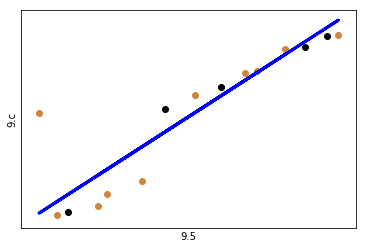

9.5 9.c
MAE: 0.36444
RMSE: 0.53659
R2: 0.685
Coefficient 0.9557834695318664
--------------------------


9.5 17.19
MAE: 1.22166
RMSE: 1.35177
R2: 0.000
Coefficient 0.2226967324463827
--------------------------


9.5 2.1
MAE: 0.13648
RMSE: 0.16621
R2: 0.928
Coefficient -0.6599776881585805
--------------------------


9.5 8.2
MAE: 0.93076
RMSE: 1.14613
R2: 0.000
Coefficient -0.059789800025135766
--------------------------


7.1 17.2
MAE: 0.95954
RMSE: 1.34981
R2: nan
Coefficient 0.25459430413582934
--------------------------


7.1 15.4
MAE: 0.28885
RMSE: 0.32686
R2: nan
Coefficient 1.080033383766131
--------------------------


7.1 15.1
MAE: 0.69498
RMSE: 0.87585
R2: nan
Coefficient 0.7529937447287339
--------------------------


7.1 9.c
MAE: 1.11652
RMSE: 1.35892
R2: nan
Coefficient 1.340800257029588
--------------------------




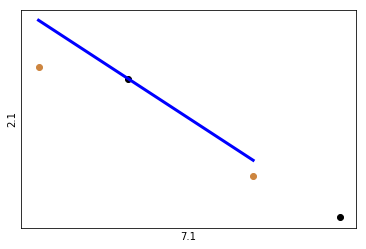

7.1 2.1
MAE: 0.34584
RMSE: 0.38803
R2: nan
Coefficient -0.9600249802972375
--------------------------


7.1 8.2
MAE: 0.91713
RMSE: 1.12372
R2: nan
Coefficient -0.5102026686831764
--------------------------


14.4 8.4
MAE: 1.08432
RMSE: 1.23373
R2: 0.000
Coefficient 1.9681638999738607
--------------------------


14.4 17.2
MAE: 0.80772
RMSE: 0.93789
R2: 0.000
Coefficient 0.5064062607142543
--------------------------


14.4 12.2
MAE: 1.08432
RMSE: 1.23373
R2: 0.000
Coefficient 1.9681638999738607
--------------------------


14.4 15.4
MAE: 0.79520
RMSE: 0.80920
R2: 0.322
Coefficient 1.0667650367331891
--------------------------


14.4 15.1
MAE: 0.82402
RMSE: 0.94269
R2: 0.228
Coefficient 0.7134474247154998
--------------------------


14.4 9.c
MAE: 0.80315
RMSE: 0.89736
R2: 0.000
Coefficient 0.8888069167501949
--------------------------


14.4 17.19
MAE: 2.40534
RMSE: 2.56811
R2: 0.000
Coefficient 3.0752404429451468
--------------------------


14.4 2.1
MAE: 0.66634
RMSE: 0.70604
R2: 0.47

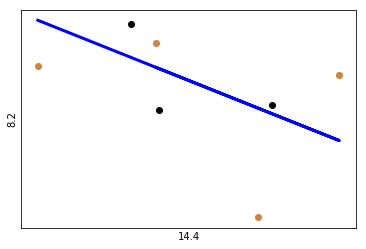

14.4 8.2
MAE: 1.21693
RMSE: 1.36225
R2: 0.000
Coefficient -0.9643538561081173
--------------------------


8.4 17.2
MAE: 0.28586
RMSE: 0.39935
R2: 0.765
Coefficient 0.832208742615309
--------------------------


8.4 12.2
MAE: 0.00000
RMSE: 0.00000
R2: 1.000
Coefficient 1.0
--------------------------


8.4 15.4
MAE: 0.16809
RMSE: 0.20631
R2: 0.931
Coefficient 0.700956811812028
--------------------------




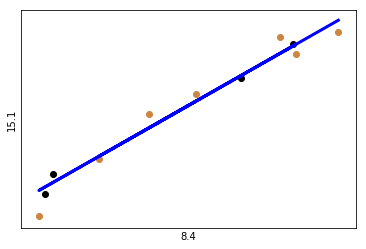

8.4 15.1
MAE: 0.17867
RMSE: 0.20222
R2: 0.949
Coefficient 0.9096168614891066
--------------------------


8.4 9.c
MAE: 0.50360
RMSE: 0.67827
R2: 0.264
Coefficient 0.8621500724721458
--------------------------


8.4 17.19
MAE: 0.38861
RMSE: 0.45288
R2: 0.616
Coefficient 1.5624920480382698
--------------------------


8.4 2.1
MAE: 0.24195
RMSE: 0.27795
R2: 0.670
Coefficient -0.30035204315887093
--------------------------


8.4 8.2
MAE: 1.10680
RMSE: 1.37982
R2: 0.000
Coefficient 0.6056557861009005
--------------------------


17.2 12.2
MAE: 0.33715
RMSE: 0.47417
R2: 0.728
Coefficient 1.18158159259803
--------------------------


17.2 15.4
MAE: 0.28380
RMSE: 0.38293
R2: 0.846
Coefficient 0.840638437337371
--------------------------


17.2 15.1
MAE: 0.34843
RMSE: 0.38188
R2: 0.857
Coefficient 0.8112178663501497
--------------------------


17.2 3.6
MAE: 9.27533
RMSE: 12.70403
R2: nan
Coefficient -7.9630611492458705
--------------------------


17.2 9.c
MAE: 0.50086
RMSE: 0.77962
R2: 0.335


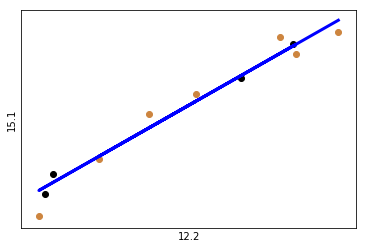

12.2 15.1
MAE: 0.17867
RMSE: 0.20222
R2: 0.949
Coefficient 0.9096168614891066
--------------------------


12.2 9.c
MAE: 0.50360
RMSE: 0.67827
R2: 0.264
Coefficient 0.8621500724721458
--------------------------


12.2 17.19
MAE: 0.38861
RMSE: 0.45288
R2: 0.616
Coefficient 1.5624920480382698
--------------------------


12.2 2.1
MAE: 0.24195
RMSE: 0.27795
R2: 0.670
Coefficient -0.30035204315887093
--------------------------


12.2 8.2
MAE: 1.10680
RMSE: 1.37982
R2: 0.000
Coefficient 0.6056557861009005
--------------------------




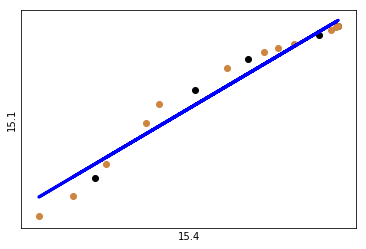

15.4 15.1
MAE: 0.17402
RMSE: 0.19979
R2: 0.961
Coefficient 0.9468755445505255
--------------------------


15.4 3.6
MAE: 1.69357
RMSE: 2.20051
R2: nan
Coefficient -1.4605258942117922
--------------------------


15.4 9.c
MAE: 0.33914
RMSE: 0.61456
R2: 0.587
Coefficient 1.0452380825578427
--------------------------


15.4 3.9
MAE: 0.18710
RMSE: 0.24335
R2: nan
Coefficient -0.669367034303834
--------------------------


15.4 16.a
MAE: 23.43373
RMSE: 26.61758
R2: 0.000
Coefficient 14.200082251154084
--------------------------


15.4 17.19
MAE: 1.22539
RMSE: 1.35765
R2: 0.000
Coefficient 0.27196612136662396
--------------------------


15.4 2.1
MAE: 0.18265
RMSE: 0.25565
R2: 0.829
Coefficient -0.7593277061045541
--------------------------


15.4 8.2
MAE: 0.85613
RMSE: 1.10328
R2: 0.000
Coefficient -0.13287870443029937
--------------------------


15.1 3.6
MAE: 2.75891
RMSE: 3.59739
R2: nan
Coefficient -2.118925034892011
--------------------------


15.1 9.c
MAE: 0.44493
RMSE: 0.74802
R2: 0

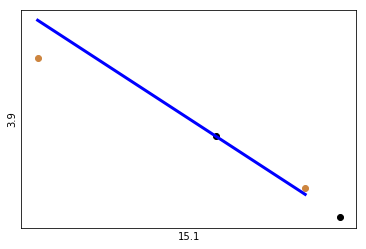

15.1 3.9
MAE: 0.31570
RMSE: 0.38559
R2: nan
Coefficient -0.958099520661679
--------------------------


15.1 16.a
MAE: 1.24498
RMSE: 1.50363
R2: 0.000
Coefficient 0.0
--------------------------


15.1 17.19
MAE: 1.20313
RMSE: 1.33092
R2: 0.000
Coefficient 0.5022992321791228
--------------------------


15.1 2.1
MAE: 0.29407
RMSE: 0.36643
R2: 0.650
Coefficient -0.7310105235835767
--------------------------


15.1 8.2
MAE: 0.88027
RMSE: 1.10922
R2: 0.000
Coefficient -0.02069425446573876
--------------------------


3.6 9.c
MAE: 0.30631
RMSE: 0.31879
R2: nan
Coefficient -0.8671357201803429
--------------------------


3.6 2.1
MAE: 0.59801
RMSE: 0.69319
R2: nan
Coefficient 0.5922963994530966
--------------------------


3.6 8.2
MAE: 0.98236
RMSE: 1.10493
R2: nan
Coefficient 0.2881645257312029
--------------------------


9.c 3.9
MAE: 0.89987
RMSE: 1.18086
R2: nan
Coefficient -0.5456263405329362
--------------------------


9.c 16.a
MAE: 0.96336
RMSE: 1.30056
R2: nan
Coefficient 0.431932123

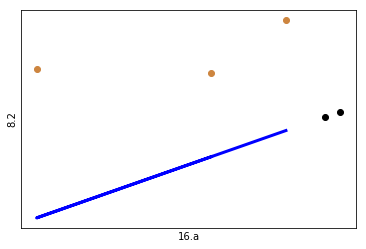

16.a 8.2
MAE: 2.37578
RMSE: 2.43935
R2: 0.000
Coefficient 0.9020980429535709
--------------------------


17.19 2.1
MAE: 0.77485
RMSE: 0.85974
R2: 0.000
Coefficient -0.8186110591410881
--------------------------


17.19 8.2
MAE: 3.84520
RMSE: 4.01574
R2: 0.000
Coefficient -2.423456949152158
--------------------------


2.1 8.2
MAE: 0.90455
RMSE: 1.14270
R2: 0.000
Coefficient 0.33573295386991653
--------------------------




In [24]:
keptPairs = list()
processedPairs = list()
discardedPairs = list()
edgecolor = list()
pairsAndRel = {}

n_connections = 0

for targetx in targets:     #loop over all targets
        
        for targety in targets:
            # avoid double processing of reverse pairs
            if not set([targetx, targety]) in processedPairs:
                processedPairs.extend([set([targetx, targety])])
                
                if not targety==targetx:


                    X = final_t_shuffled[targetx].reshape(-1,1)
                    Y = final_t_shuffled[targety].reshape(-1,1)

                    # apply mask to lists to filter out pairs containing any NaNs
                    mask = ~pd.isnull(X) & ~pd.isnull(Y)

                    X = X[mask]
                    Y = Y[mask]


                    # Split the data into training/validation sets
                    split = math.floor(2/3 * len(X))
                    X_train = X[:-split]
                    Y_train = Y[:-split]

                    X_valid = X[-split:]
                    Y_valid = Y[-split:]


                    if (len(X_train) > 1):

                        X_train = X_train.reshape(-1, 1)
                        Y_train = Y_train.reshape(-1, 1)
                        
                        X_valid = X_valid.reshape(-1, 1)
                        Y_valid = Y_valid.reshape(-1, 1)

                        linreg = linear_model.LinearRegression()
                        linreg.fit(X_train, Y_train)
                        
                        # Make predictions using the validation values
                        y_pred = linreg.predict(X_valid)
                        mae, rae, rmse, r2 = compute_error(Y_valid, y_pred)
                        
                        
                        coef = linreg.coef_[0][0]
                        
                        # filter out independant variables (coefficient close to 0, coefficient > 100)
                        if (0.9 < np.abs(coef) < 1):
                            
                            keptPairs.extend([tuple((targetx, targety))])

                            if coef > 0: edge_color = 'g'#edgecolor.append('g')
                            else: edge_color = 'r'
                                    
                            edgecolor.append(edge_color)
                            pairsAndRel[targetx, targety] = edge_color

                            plt.scatter(X_train, Y_train,  color='black')
                            plt.scatter(X_valid, Y_valid, color='peru')
                            plt.plot(X_valid, y_pred, color='blue', linewidth=3)

                            plt.xticks(())
                            plt.yticks(())
                            plt.xlabel(targetx)
                            plt.ylabel(targety)
                            plt.show()

                            n_connections = n_connections + 1

                        else: discardedPairs.extend([[targetx, targety]])

                        print(targetx, targety)
                        
                        print("MAE: %.5f\nRMSE: %.5f\nR2: %.3f" % (mae, rmse, r2))
                        print('Coefficient', coef)
                        print('--------------------------')
                        print('\n')

#print(keptPairs)

In [25]:
print("Total number of connections found: ", n_connections)

Total number of connections found:  31


In [26]:
#print(keptPairs)
#print(discardedPairs)

### Graphical Models

In [27]:
import networkx as nx

In [28]:
G1 = nx.Graph()
G1.add_edges_from(keptPairs)

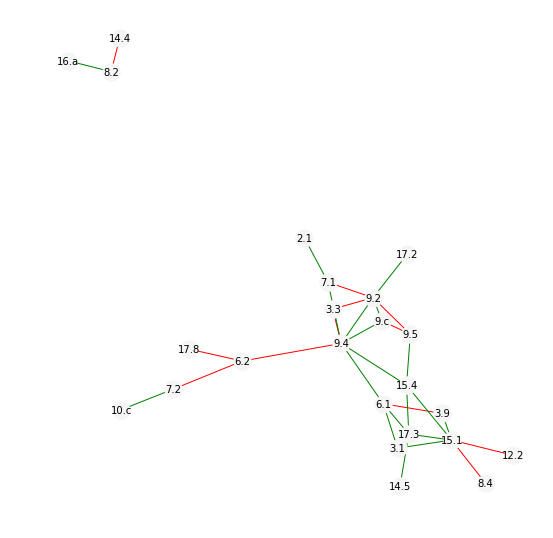

In [29]:
pos2 = nx.spring_layout(G1) # choose layout

plt.figure(1,figsize=(7,7)) 
nx.draw(G1,pos2, with_labels=True, edge_color=edgecolor, node_color='whitesmoke', font_size=10)
plt.savefig("structure.png")
plt.show()

In this plot, the most connected and therefore most influential nodes are located in the middle of the graph and are plotted closer together. There are also some targets that are only connected to one other target.

Positive interconnections are indicated by a green, negative by a red edge.

In [30]:
from matplotlib.pyplot import imshow
%matplotlib inline
from PIL import Image

size = 1024,1024
circles = Image.open("Circle-Designs-01.png")
circles = circles.resize(size, Image.ANTIALIAS)
plot = Image.open("structure.png")
plot = plot.resize(size, Image.ANTIALIAS)
overlay = Image.blend(circles, plot,alpha=0.7)
#overlay.show()
#overlay.save("final.png")

To extract the cliques (complete subgraphs of the graph) that already are visible in the graph above, we use networkx' inbuilt function find_cliques(G).

We would like to make our imputations first on one of these cliques, actually on one that has the most members.


In [31]:
clique_list = list(nx.find_cliques(G1))
clique_list

[['3.9', '15.1'],
 ['3.9', '6.1'],
 ['9.4', '15.4'],
 ['9.4', '6.1'],
 ['9.4', '6.2'],
 ['9.4', '9.2', '9.c'],
 ['9.4', '9.2', '3.3'],
 ['9.4', '9.2', '7.1'],
 ['3.1', '15.1'],
 ['3.1', '6.1'],
 ['17.8', '6.2'],
 ['12.2', '15.1'],
 ['16.a', '8.2'],
 ['7.2', '10.c'],
 ['7.2', '6.2'],
 ['8.2', '14.4'],
 ['15.1', '15.4', '17.3'],
 ['15.1', '8.4'],
 ['17.3', '6.1'],
 ['17.3', '14.5'],
 ['9.5', '9.c', '9.2'],
 ['9.5', '15.4'],
 ['2.1', '7.1'],
 ['17.2', '9.2']]

In [32]:
# finding clique containing most nodes
length = 0
for c in clique_list:
    if len(c) > length:
        length = len(c)
        max_clique = c

In [33]:
import itertools

def complete_graph_from_list(L, create_using=None):
    G = nx.empty_graph()
    if len(L)>1:
        if G.is_directed():
            edges = itertools.permutations(L,2)
        else:
            edges = itertools.combinations(L,2)
        G.add_edges_from(edges)
    return G


In [34]:
cliqueGraph = complete_graph_from_list(max_clique)

In [35]:
cliqueGraph_edges = list(cliqueGraph.edges)
pairsDictListKeys = list(pairsAndRel.keys())

In [36]:
clique_e_color = []
for edge in cliqueGraph_edges:
    if edge in pairsDictListKeys:
        clique_e_color.append(pairsAndRel[edge])
    elif edge[::-1] in pairsDictListKeys:
        clique_e_color.append(pairsAndRel[edge[::-1]])

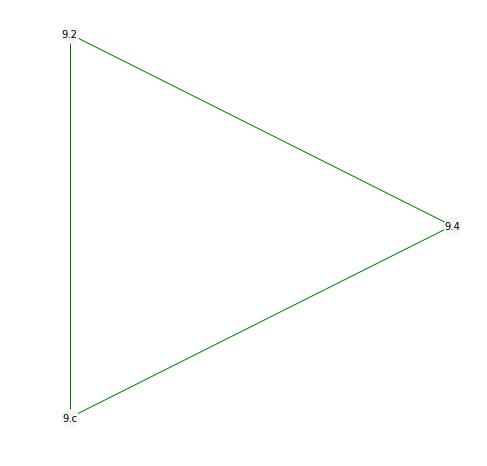

In [37]:
#cliqueGraph.add_nodes_from(max_clique)
pos9 = nx.shell_layout(cliqueGraph)
plt.figure(1,figsize=(6,6)) 
nx.draw(cliqueGraph,pos9, with_labels=True, font_size=10, edge_color=clique_e_color, node_color='whitesmoke')
plt.show()

In [50]:
print('Our max clique consists of the following targets: ', cliqueGraph.nodes)

Our max clique consists of the following targets:  ['9.4', '9.2', '9.c']


As one can see in this graph, the interconnections are all positive.

# 2. Build temporal model to infer missing observations

We have a temporal model with missing observations as NaNs, and want to infer them according to their correlated targets and their own time series development. Therefore, we design a linear dynamical system with inputs, including an autoregressive model of order 2.

## Define STAN model

From now on, we can actually forget all information we've gotten so far. With the implementation in STAN, we will gain insights for the following two questions in one single model (wow - so amazing :-) ):

**1. How are Targets correlated?**

**2. What are expectable values for missing observations (imputing)?**

Note that we observe two time-series simultaneously. We will model the correlations between the two time-series in the latent state $\textbf{z}_t$. We will assume that our latent state is 2-dimensional $\textbf{z}_t = \{z_{t,1},z_{t,2}\}$ with latent dynamics:
\begin{align}
\textbf{z}_t &\sim \mathcal{N}(\boldsymbol\beta \textbf{z}_{t-1}, \boldsymbol\Sigma)
\end{align}
And likelihoods:
\begin{align}
y_{t,1} &\sim \mathcal{N}(z_{t,1}, \sigma^2)\\
y_{t,2} &\sim \mathcal{N}(z_{t,2}, \sigma^2)
\end{align}
Or (equivalent):
\begin{align}
\textbf{y}_t &\sim \mathcal{N}(\textbf{z}_t, \sigma^2 \textbf{I})
\end{align}

The key element in the model described above is the **covariance matrix $\boldsymbol\Sigma$** which embodies the object that will allow us to capture the correlations between the two time-series.

In STAN, the recommended approach is to decompose the covariance matrix $\boldsymbol\Sigma$ into a *scale* and a *matrix*, but we are able to do so in a more natural way based on the actual variable scales and a correlation matrix. Specifically, we define:

\begin{align}
\boldsymbol\Sigma = \mbox{diag_matrix}(\boldsymbol\tau) \, \boldsymbol\Omega \, \mbox{diag_matrix}(\boldsymbol\tau)
\end{align}

where $\mbox{diag_matrix}(\boldsymbol\tau)$ denotes a diagonal matrix with diagonal elements given by the vector $\boldsymbol\tau$. In this parameterization, $\boldsymbol\Omega$ can be regarded as a correlation matrix and $\boldsymbol\tau$ is a vector of coefficient scales.

Similar to any other variable, we also must assign priors to $\boldsymbol\tau$ and $\boldsymbol\Omega$. The components of the scale vector $\boldsymbol\tau$ can be given any reasonable prior for scales, but something weakly informative like a half-Cauchy distribution with a small scale is recommended, such as:

\begin{align}
\boldsymbol\tau ∼ Cauchy(0, 1.0) , \, \mbox{with the constraint:} \, \boldsymbol\tau > 0
\end{align}

As for the correlation matrix $\boldsymbol\Omega$, the STAN manual recommends a LKJ prior like:

\begin{align}
\boldsymbol\Omega ∼ LKJCorr(10.0)
\end{align}

Finally, we can define a multivariate Gaussian with parameters $\boldsymbol\mu$, $\boldsymbol\tau$ and $\boldsymbol\Omega$ using:

    multi_normal(mu, quad_form_diag(Omega, tau))


To impute missing observations, we do

\begin{align}
y_{t} &\sim \mathcal{N} \Big(\beta_{1} y_{t-1} + \beta_{2} y_{t-2} + ... + \beta_{T} y_{t-T} \Big)
\end{align}


**Note** that we want to make the missing observation dependent on two previous observations. This is equivalent to define an autoregressive model of order 2.

<img src="pgm.png">

In [39]:
SDG_STAN="""
data {
    int<lower = 0> N_obs1;
    int<lower = 0> N_mis1;    // how many do we want to infer
    int<lower = 0> N_obs2;  
    int<lower = 0> N_mis2;
    int<lower = 1, upper = N_obs1 + N_mis1> ix_obs1[N_obs1];    // index for observed time steps of target 1
    int<lower = 1, upper = N_obs1 + N_mis1> ix_mis1[N_mis1];
    int<lower = 1, upper = N_obs2 + N_mis2> ix_obs2[N_obs2];    // index for observed time steps of target 2
    int<lower = 1, upper = N_obs2 + N_mis2> ix_mis2[N_mis2];
    real y_obs1[N_obs1];         // observed time-series data for target 1
    real y_obs2[N_obs2];         // observed time-series data for target 2
}

transformed data {
    int<lower = 0> T = N_obs1 + N_mis1;  // length of the time-series
}

parameters {
    vector[2] beta[2];            // state transition coefficients 
    corr_matrix[2] Omega;       // gives us the correlation with **Omega[1,2]=Omega[2,1]=Cov(1,2)**; Omega[1,1]=Var(1);Omega[2,2]=Var(2)    1 is target 1, 2 is target 2
    vector<lower=0>[2] tau;     // uncertainty in the latent space
    real<lower=0> sigma;       // observation noise
    matrix[T,2] z;             // vector of latent states
    real y_mis1[N_mis1];        // missing time-series data to infer for target 1
    real y_mis2[N_mis2];        // missing time-series data to infer for target 2
}

transformed parameters {
    real y1[T];
    real y2[T];
    matrix[2,2] L_sigma;
    y1[ix_obs1] = y_obs1;
    y1[ix_mis1] = y_mis1;
    y2[ix_obs2] = y_obs2;
    y2[ix_mis2] = y_mis2;
}

model {
    for(i in 1:2)                   
        beta[i] ~ normal(0,1);            // prior on the auto-regressive coefficients
    tau ~ cauchy(0,1);
    Omega ~ lkj_corr(1);         // STAN manual Section 63.1 (recommendation is lkj_corr)
    sigma ~ cauchy(0,5);            // prior on the variance
    
    z[1,:] ~ normal(0,1);           // prior on first latent state
    z[2,:] ~ normal(0,1);           // prior on second latent state
    
    for(t in 3:T) {
        vector[2] mu;                          // mu is a vector of the means of our multivariate normal 
        mu[1] = beta[1]' * z[(t-2):(t-1),1];   // mu[1] is the mean of target 1 
        mu[2] = beta[2]' * z[(t-2):(t-1),2];   // mu[2] is the mean of target 2
        z[t,:] ~ multi_normal(mu, quad_form_diag(Omega, tau)); // latent dynamics
    }
    
    y1 ~ normal(z[:,1], sigma);    // likelihood for target 1
    y2 ~ normal(z[:,2], sigma);    // likelihood for target 2
}
"""

### What targets are in our clique?

We will work for the rest of the notebook with this single clique.

In [40]:
clique_nodes = list(cliqueGraph.nodes)
clique_nodes

['9.4', '9.2', '9.c']

In [41]:
clique_df_t = final_t[clique_nodes]

In [42]:
clique_df_t = clique_df_t[clique_df_t.index > '1990']

In [51]:
g1_nodes = list(G1.nodes)
g1_df_t = final_t[g1_nodes]
g1_df_t = g1_df_t[g1_df_t.index > '1990']

## What is observed, what is missing?

- N_obs: Number of observed values (length of loc array)
- N_mis: Number of missing values (length of loc array)
- ix_obs: indices of observed values
- ix_mis: indices of missing values
- y_obs: observed values

In [43]:
# prepare data for STAN model
def prepareInputData(df, target1, target2):
    t1_list = df[target1].tolist()
    t2_list = df[target2].tolist()
    
    ix_obs1 = np.where(~np.isnan(t1_list))[0]
    ix_obs2 = np.where(~np.isnan(t2_list))[0]
    
    ix_mis1 = np.where(np.isnan(t1_list))[0]
    ix_mis2 = np.where(np.isnan(t2_list))[0]
    
    y_obs1 = [t1_list[index] for index in ix_obs1]
    y_obs2 = [t2_list[index] for index in ix_obs2]
    
    N_obs1 = len(ix_obs1)
    N_obs2 = len(ix_obs2)
    
    N_mis1 = len(ix_mis1)
    N_mis2 = len(ix_mis2)
    
    data = {'N_obs1': N_obs1, 'N_mis1': N_mis1, 'N_obs2': N_obs2, 'N_mis2': N_mis2,
            'ix_obs1': ix_obs1+1, 'ix_mis1': ix_mis1+1, 'y_obs1': y_obs1, 
            'ix_obs2': ix_obs2+1, 'ix_mis2': ix_mis2+1, 'y_obs2': y_obs2}
    
    return data

In [44]:
%%time
# create STAN model object (compile STAN model)
sm = pystan.StanModel(model_code=SDG_STAN)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_c2c8db35d3d6b106a2010ff56a7e73b8 NOW.


CPU times: user 1.47 s, sys: 143 ms, total: 1.61 s
Wall time: 1min 2s


### How we find the highest correlated pairs
We use here Pearson's r as a correlation coefficient what returns us *only* the pairs of random variables which are highest correlated in a linear manner. But, the world is not linear; so, we could have also used [this](http://old.econ.ucdavis.edu/faculty/cameron/research/je97preprint.pdf) correlation coefficient.

In [45]:
from scipy.stats import pearsonr

In [46]:
def calcCorr(df, target1, target2):
    # list of values
    t1_list = df[target1].tolist()
    t2_list = df[target2].tolist()
                    
    #correlation between two targets
    mask = ~pd.isnull(t1_list) & ~pd.isnull(t2_list)
    t1_list = list(itertools.compress(t1_list, mask))#t1_list[mask]
    t2_list = list(itertools.compress(t2_list, mask))

                    
    #correlation between two targets
    corrCoef = pearsonr(t1_list, t2_list)[0]
    
    return corrCoef

To find out which pairs would give the most cartain results after inference, we want to find the pairs that have the highest correlation between each other (lowest uncertainty in prediction). This is why we first calculate the correlation coefficient and choose the pairs that give the highest correlation coefficients.

In [69]:
for pair in keptPairs:
    print(pair)

('9.4', '6.2')
('9.4', '9.2')
('9.4', '3.3')
('9.4', '6.1')
('9.4', '7.1')
('9.4', '15.4')
('9.4', '9.c')
('3.1', '6.1')
('3.1', '15.1')
('17.8', '6.2')
('6.2', '7.2')
('10.c', '7.2')
('17.3', '14.5')
('17.3', '6.1')
('17.3', '15.4')
('17.3', '15.1')
('9.2', '3.3')
('9.2', '9.5')
('9.2', '7.1')
('9.2', '17.2')
('9.2', '9.c')
('6.1', '3.9')
('9.5', '15.4')
('9.5', '9.c')
('7.1', '2.1')
('14.4', '8.2')
('8.4', '15.1')
('12.2', '15.1')
('15.4', '15.1')
('15.1', '3.9')
('16.a', '8.2')


In [76]:
processedPairs = []
bestCorrPairs = []
corrCoefs = []
for pair in keptPairs:
    if pair not in processedPairs:
        processedPairs.append(pair)
        bestCorrCoef = 0
        targetx = pair[0]
        t_y = []
        for p in keptPairs:
            if targetx in p:
                if (p[0]!=targetx): t_y.append(p[0])
                else: t_y.append(p[1])
            else: continue
        for targety in t_y:
            corr = calcCorr(final_t,targetx, targety)
            if (np.abs(corr) > np.abs(bestCorrCoef) and not (corr==0 or corr==1)):
                bestCorrCoef = corr
                bestPair = tuple([targetx, targety])
            else: continue

        bestCorrPairs.append(bestPair)
        corrCoefs.append(bestCorrCoef)
    else: continue

for i in range(0,len(bestCorrPairs)):
    print(bestCorrPairs[i], ': ', corrCoefs[i])

('9.4', '15.4') :  0.9906385237419475
('9.4', '15.4') :  0.9906385237419475
('9.4', '15.4') :  0.9906385237419475
('9.4', '15.4') :  0.9906385237419475
('9.4', '15.4') :  0.9906385237419475
('9.4', '15.4') :  0.9906385237419475
('9.4', '15.4') :  0.9906385237419475
('3.1', '15.1') :  -0.9815967899407816
('3.1', '15.1') :  -0.9815967899407816
('17.8', '6.2') :  -0.9982604771744984
('6.2', '17.8') :  -0.9982604771744984
('10.c', '7.2') :  -0.8082515774139288
('17.3', '15.1') :  0.9810874111013809
('17.3', '15.1') :  0.9810874111013809
('17.3', '15.1') :  0.9810874111013809
('17.3', '15.1') :  0.9810874111013809
('9.2', '7.1') :  0.986711676584663
('9.2', '7.1') :  0.986711676584663
('9.2', '7.1') :  0.986711676584663
('9.2', '7.1') :  0.986711676584663
('9.2', '7.1') :  0.986711676584663
('6.1', '3.9') :  -0.9755620082949763
('9.5', '15.4') :  0.9930704122763047
('9.5', '15.4') :  0.9930704122763047
('7.1', '9.4') :  0.9903241536157872
('14.4', '8.2') :  -0.4148092493626464
('8.4', '15.1

# find pairs with best correlation coefficient in clique
bestCorrPairs = []
processedPairs = []
corrCoefs = []

for targetx in clique_nodes:     #loop over all rows
    
    bestCorrCoef = 0
    
    for targety in clique_nodes:    #loop over all rows except the one we're in now
        # avoid double processing of reverse pairs
        if not set([targetx, targety]) in processedPairs:
            processedPairs.extend([set([targetx, targety])])
                
            if not targety==targetx:
                corr = calcCorr(clique_df_t,targetx, targety)
                if (np.abs(corr) > np.abs(bestCorrCoef) and not (corr==0 or corr==1)):
                    bestCorrCoef = corr
                    bestPair = tuple([targetx, targety])
        
        else: continue           
    
    bestCorrPairs.append(bestPair)a
    corrCoefs.append(bestCorrCoef)
    
for i in range(0,len(bestCorrPairs)):
    print(bestCorrPairs[i], ': ', corrCoefs[i])

In [48]:
# hyperparameter
startyear=1990

The predetermined pairs which have the Pearson r correlation coefficient are now taken further into account to impute values for years which we do not have observations for.

('9.2', '9.c')


/Users/GalinaJonat/anaconda/lib/python3.6/site-packages/pystan/misc.py:399: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.issubdtype(np.asarray(v).dtype, float):


Inference for Stan model: anon_model_c2c8db35d3d6b106a2010ff56a7e73b8.
4 chains, each with iter=1000; warmup=500; thin=1; 
post-warmup draws per chain=500, total post-warmup draws=2000.

               mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
beta[0,0]      0.02    0.01   0.28  -0.51  -0.17   0.01   0.22   0.57    715    1.0
beta[1,0]     -0.33    0.02   0.33  -0.82  -0.57  -0.39  -0.13   0.43    239   1.01
beta[0,1]      0.65    0.01   0.28   0.09   0.46   0.65   0.83    1.2    564    1.0
beta[1,1]      1.13    0.02   0.34   0.34   0.93   1.18   1.38   1.66    238   1.01
Omega[0,0]      1.0     0.0    0.0    1.0    1.0    1.0    1.0    1.0   2000    nan
Omega[1,0]     0.65    0.01   0.26-6.6e-3    0.5   0.71   0.85   0.95    373   1.01
Omega[0,1]     0.65    0.01   0.26-6.6e-3    0.5   0.71   0.85   0.95    373   1.01
Omega[1,1]      1.0 1.3e-185.7e-17    1.0    1.0    1.0    1.0    1.0   2000    nan
tau[0]         0.64  9.1e-3   0.17   0.36   0.53   0.62  

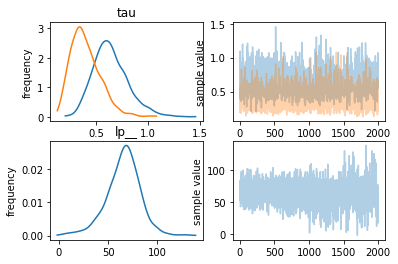

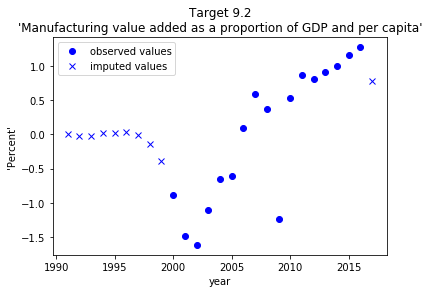

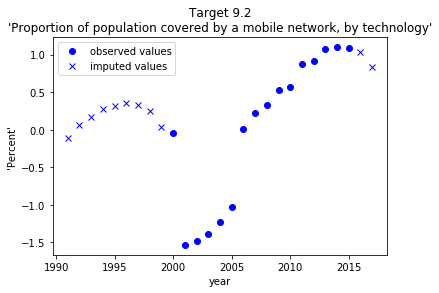

('9.4', '9.2')
Inference for Stan model: anon_model_c2c8db35d3d6b106a2010ff56a7e73b8.
4 chains, each with iter=1000; warmup=500; thin=1; 
post-warmup draws per chain=500, total post-warmup draws=2000.

               mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
beta[0,0]     -0.55    0.03   0.16  -0.84  -0.66  -0.53  -0.46  -0.22     27   1.07
beta[1,0]     -0.09    0.01   0.21  -0.56  -0.22  -0.02   0.02    0.3    211   1.04
beta[0,1]      1.47    0.03   0.16   1.15   1.38   1.45   1.58   1.76     27   1.06
beta[1,1]      0.91    0.01    0.2    0.5   0.82   0.85   1.04   1.34    275   1.02
Omega[0,0]      1.0     0.0    0.0    1.0    1.0    1.0    1.0    1.0   2000    nan
Omega[1,0]     0.71    0.01   0.17   0.29   0.64    0.7   0.85   0.95    197   1.03
Omega[0,1]     0.71    0.01   0.17   0.29   0.64    0.7   0.85   0.95    197   1.03
Omega[1,1]      1.0 1.9e-177.9e-17    1.0    1.0    1.0    1.0    1.0     18    nan
tau[0]         0.21  2.5e-3   0.05   0.13 

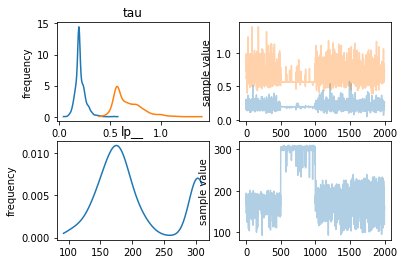

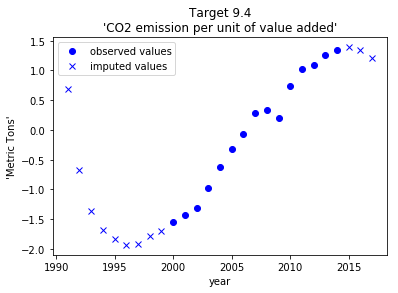

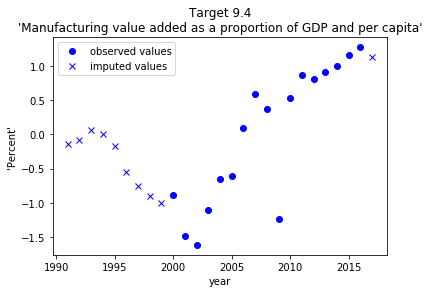

In [49]:
for pair in list(set(bestCorrPairs)):
    targetx = pair[0]
    targety = pair[1]

    # prepare input data
    inData = prepareInputData(clique_df_t, targetx, targety)
    print(pair)

    # run inference using MCMC sampling
    fit = sm.sampling(data=inData, iter=1000, chains=4, algorithm="NUTS", seed=42, verbose=True)
    print(fit)
    
    # what do we actually want to show? sigma and tau are performance measurements.
    fit.plot(["tau","lp__"]) # take vars from temporal model
    plt.show()

    samples = fit.extract(permuted=True)
    
    # get values for plots
    # convert indices back to year values
    ix_mis1 = inData['ix_mis1']+startyear
    ix_mis2 = inData['ix_mis2']+startyear
    ix_obs1 = inData['ix_obs1']+startyear
    ix_obs2 = inData['ix_obs2']+startyear
    
    y_mis1 = samples['y_mis1'].mean(axis=0)
    y_mis2 = samples['y_mis2'].mean(axis=0)
    y_obs1 = inData['y_obs1']
    y_obs2 = inData['y_obs2']
    
    
    # define title and labels from original dataframe
    y1_df = merged_df[merged_df['Target']==pair[0]]
    y2_df = merged_df[merged_df['Target']==pair[1]]
    y1_title = 'Target '+pair[0]+'\n'+str(y1_df['Indicator Description'].values).replace('[','').replace(']','')
    y1_label = str(y1_df['Unit'].values).replace('[','').replace(']','')
    y2_title = 'Target '+pair[0]+'\n'+str(y2_df['Indicator Description'].values).replace('[','').replace(']','')
    y2_label = str(y2_df['Unit'].values).replace('[','').replace(']','')
    
    # plot with imputed values of target 1
    plt.plot(ix_obs1, y_obs1, "bo")
    plt.plot(ix_mis1, y_mis1, "bx")
    plt.title(y1_title)
    plt.legend(["observed values","imputed values"])
    plt.xlabel('year')
    plt.ylabel(y1_label)
    plt.show()
    
    # plot with imputed values of target 2
    plt.plot(ix_obs2, y_obs2, "bo")
    plt.plot(ix_mis2, y_mis2, "bx")
    plt.title(y2_title)
    plt.legend(["observed values", "imputed values"])
    plt.xlabel('year')
    plt.ylabel(y2_label)
    plt.show()

## Open questions: What we haven't understood so far

- Omega[1,0] is a value of Omega that gives us the correlation between Target 1 and 2. What kind of correlation measure is it? How can it be different/lower from our previously found Pearson r?
